# Trajectory Optimisation

In [1]:
import numpy as np
import torch
from torchdyn.models import NeuralODE

import matplotlib.pyplot as plt
import sys
import time
sys.path.append("../../")

### Set Seed Here

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Define the Dynamic
- Then we can replace this with a NN

In [3]:
from nn import MLP

In [4]:
class Pendulum(torch.nn.Module):
    def __init__(self):
        super(Pendulum, self).__init__()
        self.g = 10.
        self.m = 1.
        self.l = 1.

        # self._policy = MLP([3, 16, 16, 1], activation='softplus')
        self._policy = MLP([3, 32, 32, 1], activation='tanh')
    
    def forward(self, x):
        th = x[:, 0]
        dth = x[:, 1]
        cth = torch.cos(th)
        sth = torch.sin(th)
        full_state = torch.stack([cth, sth, dth], dim=1)
        action = self.policy(full_state)[:, 0]

        dth = x[:, 1]
        ddth = (-3 * self.g / (2 * self.l) * torch.sin(th) + 3. / (self.m * self.l ** 2) * action)
        return torch.stack([dth, ddth], dim=1)
    
    def policy(self, x):
        action = self._policy(x)
        # action = torch.tanh(action) * 2
        # action = torch.cos(action) * 2
        # action = torch.clamp(action, min=-2, max=2)
        return action

In [5]:
pendulum = Pendulum()
pendulumODE = NeuralODE(pendulum, sensitivity='adjoint', solver='rk4').to(device)

In [6]:
models = torch.load("../Pendulum/model/gradvsODEvsFD.pt")
lagODE_model = torch.load("../Pendulum/model/gradvsODEvsFD_lagODE.pt")
models.insert(1, lagODE_model )

for model in models:
    model.eval()
None

In [7]:
class Pendulum_approx(torch.nn.Module):
    def __init__(self, model: torch.nn.Module):
        super(Pendulum_approx, self).__init__()
        self.g = 10.
        self.m = 1.
        self.l = 1.

        # self._policy = MLP([3, 16, 16, 1], activation='softplus')
        self._policy = MLP([3, 32, 32, 1], activation='tanh')
        self._model = model
    
    def forward(self, x): 
        th = x[:, 0]
        dth = x[:, 1]
        cth = torch.cos(th)
        sth = torch.sin(th)
        full_state = torch.stack([cth, sth, dth], dim=1)
        action = self.policy(full_state)[:, 0]

        q_dq_u = torch.stack([sth, -cth, dth, action], dim=1)
        output = self._model.defunc(0, q_dq_u).detach()
        # dth = torch.sqrt(output[:, 0] ** 2 + output[:, 1] ** 2) * torch.sign(dth)
        dth = dth
        ddth = output[:, 2]

        return torch.stack([dth, ddth], dim=1)
    
    def policy(self, x):
        action = self._policy(x)
        # action = torch.tanh(action) * 2
        # action = torch.cos(action) * 2
        # action = torch.clamp(action, min=-2, max=2)
        return action

In [8]:
pendulum_approx = Pendulum_approx(models[0])
pendulum_approxODE = NeuralODE(pendulum_approx, sensitivity='adjoint', solver='rk4').to(device)

In [9]:
# test_model = pendulum_approxODE
test_model = pendulumODE

In [10]:
test_model.defunc(0, torch.tensor([3 * np.pi / 4, 2]).detach().view(1, -1))

tensor([[  2.0000, -11.7393]], grad_fn=<StackBackward>)

### Check the Model

In [11]:
init_state = torch.tensor([3 * np.pi / 5, 0]).reshape(1, -1).float()
t_span = torch.linspace(0, 5, 100)
traj = test_model.trajectory(init_state, t_span)
dummy = torch.stack([torch.cos(traj[:, 0, 0]), torch.sin(traj[:, 0, 0]), traj[:, 0, 1]], dim=1)
actions = test_model.defunc.m.policy(dummy)
print(traj.shape)
print(actions.shape)

torch.Size([100, 1, 2])
torch.Size([100, 1])


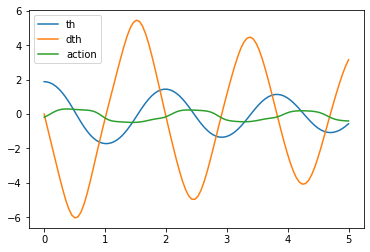

In [12]:
plt.plot(t_span.detach().numpy(), traj[:, 0, 0:2].detach().numpy())
plt.plot(t_span.detach().numpy(), actions.detach().numpy())
plt.legend(['th', 'dth', 'action'])
# plt.ylim(-2, 2)

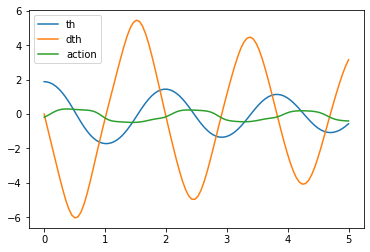

In [13]:
plt.plot(t_span.detach().numpy(), traj[:, 0, 0:2].detach().numpy())
plt.plot(t_span.detach().numpy(), actions.detach().numpy())
plt.legend(['th', 'dth', 'action'])
# plt.ylim(-2, 2)

### Optimise the control

In [14]:
import torch.optim as optim

In [15]:
# optimizer = optim.LBFGS(pendulum.parameters(), lr=0.05)
optimizer = optim.Adam(pendulum.parameters(), lr=0.05)

In [16]:
def total_cost(traj, actions):
    theta = traj[:, :, 0]
    theta_dt = traj[:, :, 1]
    actions = actions[:, :, 0]

    costs = angle_normalize(theta + np.pi) ** 2 + 0.1 * theta_dt ** 2 + 0.001 * actions ** 2
#     costs = torch.zeros_like(theta)
#     costs += 10 * (torch.cos(theta + np.pi) - 1) ** 2
#     costs += 0.1 * theta_dt ** 2
#     costs += 0.001 * actions ** 2

    # costs = angle_normalize(theta + np.pi) ** 2 + 0.1 * theta_dt ** 2
    costs += 0.01 * max(actions ** 2)
    
    # costs = (1 - torch.exp(-costs / (2 * 16)))
    return costs.sum()

def angle_normalize(x):
    return (((x + np.pi) % (2 * np.pi)) - np.pi)

0 tensor(2899.9744, grad_fn=<SumBackward0>)


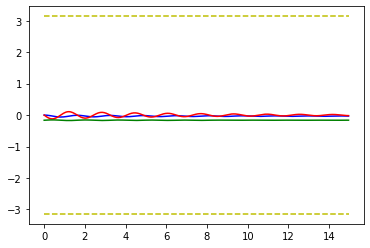

1 tensor(1971.6569, grad_fn=<SumBackward0>)


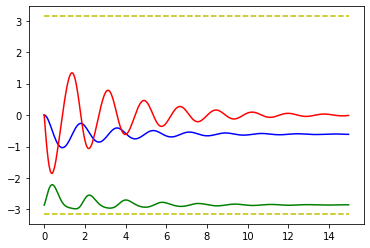

2 tensor(1559.5725, grad_fn=<SumBackward0>)


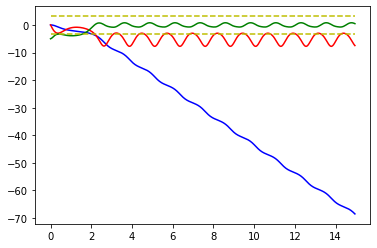

3 tensor(1119.1562, grad_fn=<SumBackward0>)


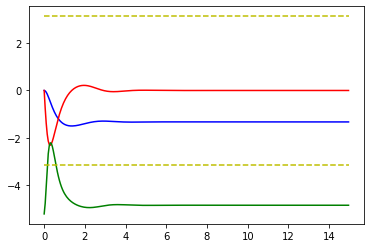

4 tensor(872.1481, grad_fn=<SumBackward0>)


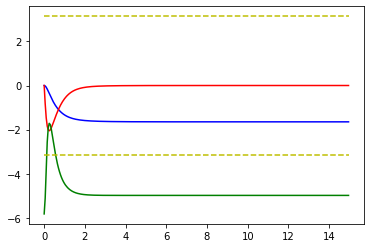

5 tensor(557.1476, grad_fn=<SumBackward0>)


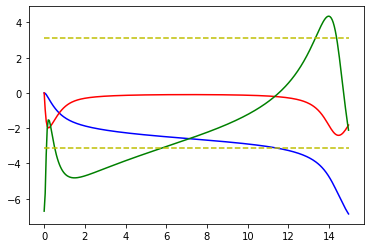

6 tensor(835.6846, grad_fn=<SumBackward0>)


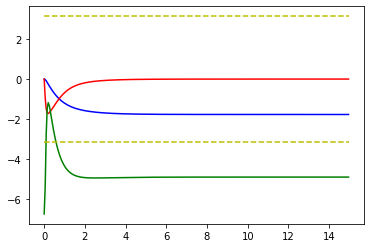

7 tensor(1004.4257, grad_fn=<SumBackward0>)


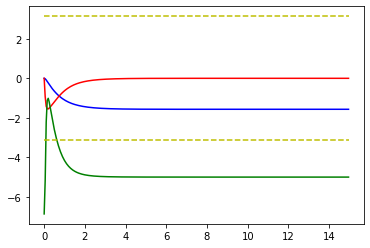

8 tensor(1090.8461, grad_fn=<SumBackward0>)


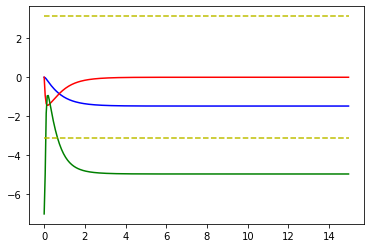

9 tensor(1134.4172, grad_fn=<SumBackward0>)


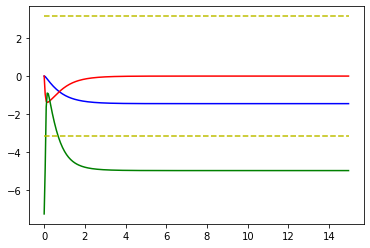

10 tensor(1150.3632, grad_fn=<SumBackward0>)


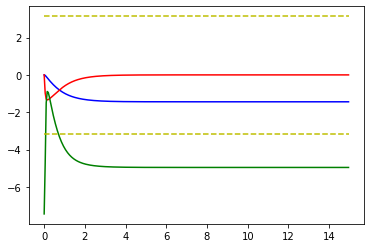

11 tensor(1147.0452, grad_fn=<SumBackward0>)


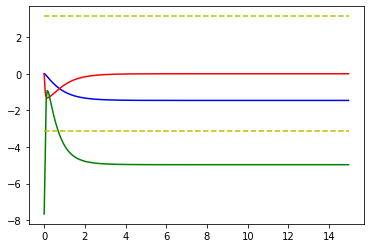

12 tensor(1129.9692, grad_fn=<SumBackward0>)


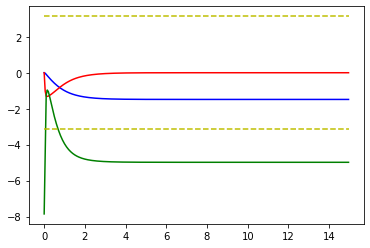

13 tensor(1103.1113, grad_fn=<SumBackward0>)


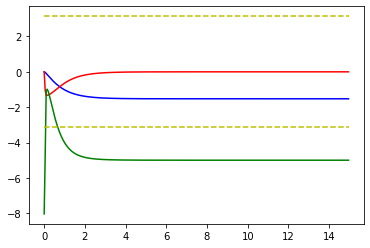

14 tensor(1069.4619, grad_fn=<SumBackward0>)


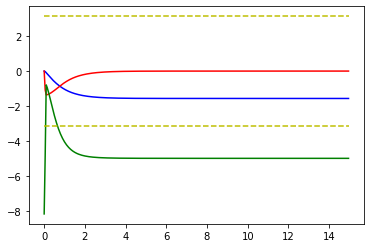

15 tensor(1031.2933, grad_fn=<SumBackward0>)


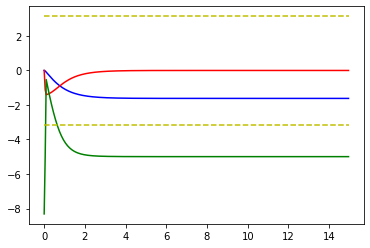

16 tensor(990.3207, grad_fn=<SumBackward0>)


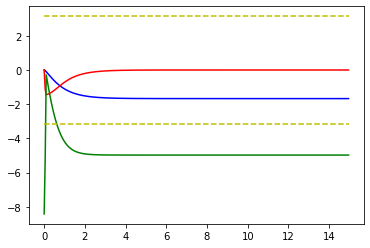

17 tensor(947.8121, grad_fn=<SumBackward0>)


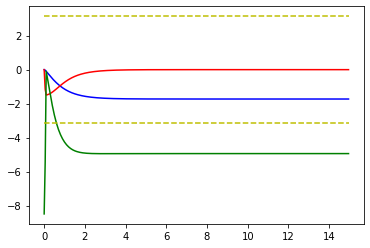

18 tensor(904.6437, grad_fn=<SumBackward0>)


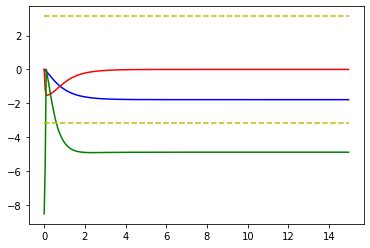

19 tensor(861.4004, grad_fn=<SumBackward0>)


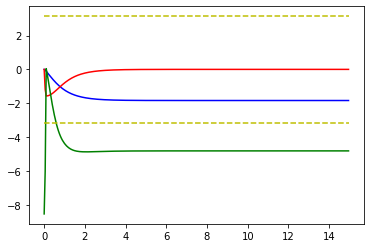

20 tensor(818.4767, grad_fn=<SumBackward0>)


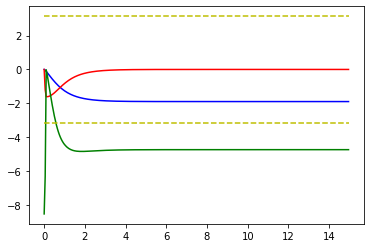

21 tensor(776.1436, grad_fn=<SumBackward0>)


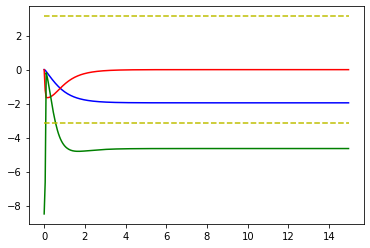

22 tensor(734.6041, grad_fn=<SumBackward0>)


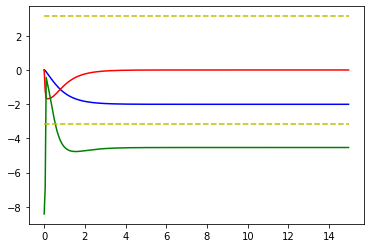

23 tensor(694.1224, grad_fn=<SumBackward0>)


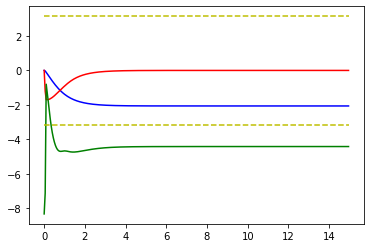

24 tensor(654.9582, grad_fn=<SumBackward0>)


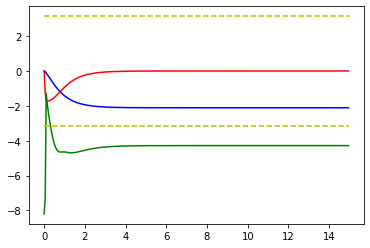

25 tensor(617.3549, grad_fn=<SumBackward0>)


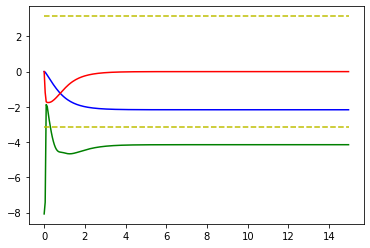

26 tensor(581.3837, grad_fn=<SumBackward0>)


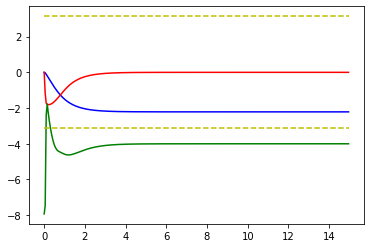

27 tensor(547.0085, grad_fn=<SumBackward0>)


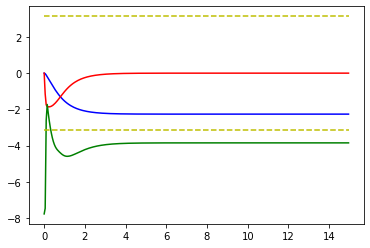

28 tensor(514.1623, grad_fn=<SumBackward0>)


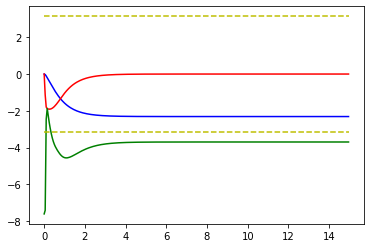

29 tensor(482.7934, grad_fn=<SumBackward0>)


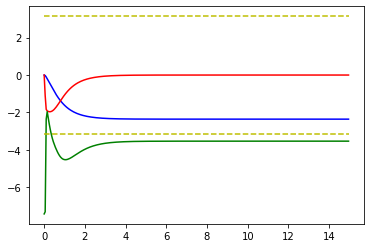

30 tensor(452.8608, grad_fn=<SumBackward0>)


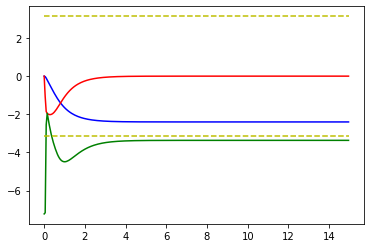

31 tensor(424.3479, grad_fn=<SumBackward0>)


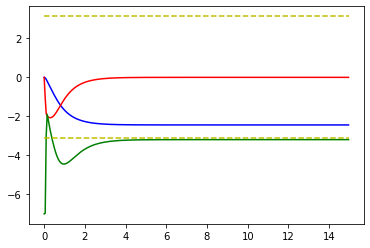

32 tensor(397.2531, grad_fn=<SumBackward0>)


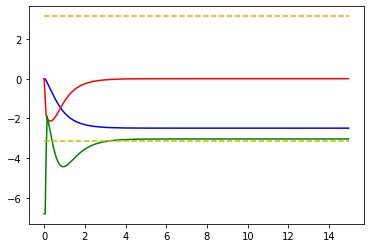

33 tensor(371.9738, grad_fn=<SumBackward0>)


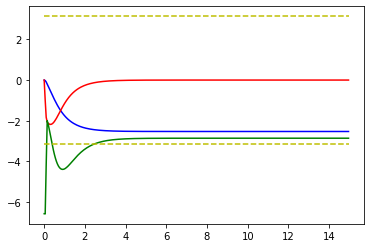

34 tensor(347.9890, grad_fn=<SumBackward0>)


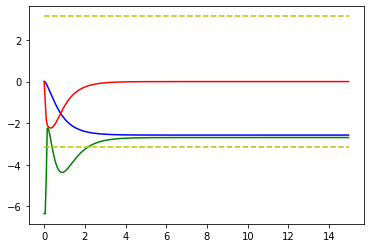

35 tensor(325.2551, grad_fn=<SumBackward0>)


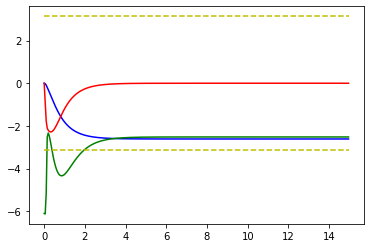

36 tensor(303.8197, grad_fn=<SumBackward0>)


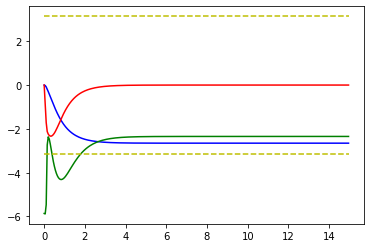

37 tensor(283.7000, grad_fn=<SumBackward0>)


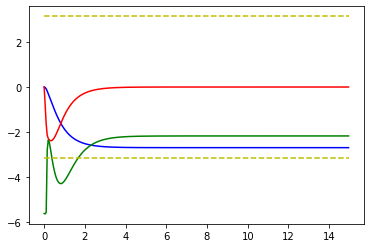

38 tensor(268.1614, grad_fn=<SumBackward0>)


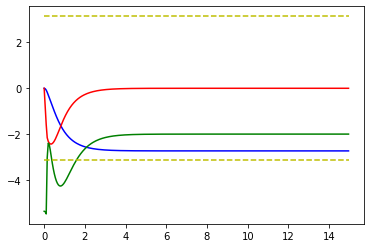

39 tensor(252.0795, grad_fn=<SumBackward0>)


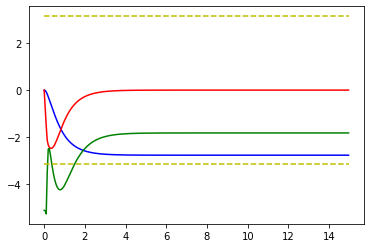

40 tensor(235.4271, grad_fn=<SumBackward0>)


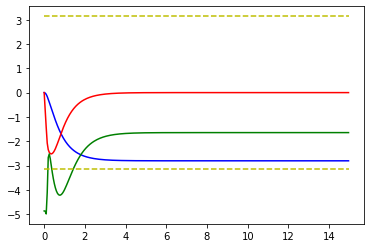

41 tensor(219.8525, grad_fn=<SumBackward0>)


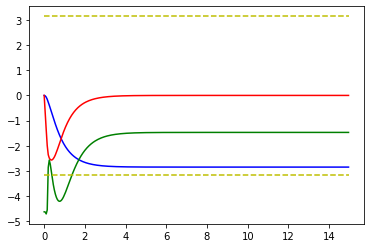

42 tensor(211.8146, grad_fn=<SumBackward0>)


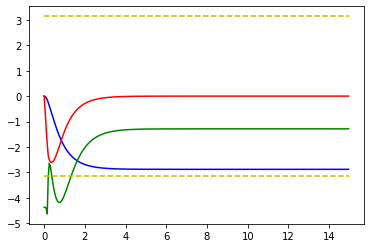

43 tensor(200.2997, grad_fn=<SumBackward0>)


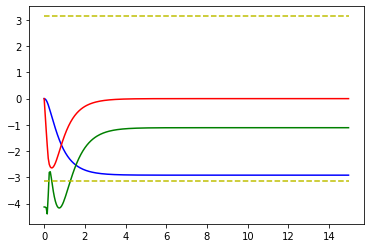

44 tensor(190.2730, grad_fn=<SumBackward0>)


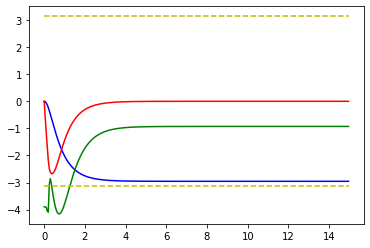

45 tensor(186.8435, grad_fn=<SumBackward0>)


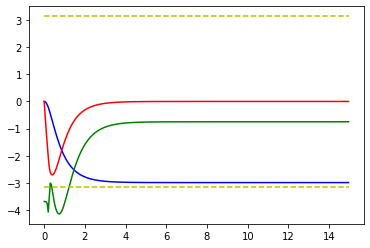

46 tensor(184.1944, grad_fn=<SumBackward0>)


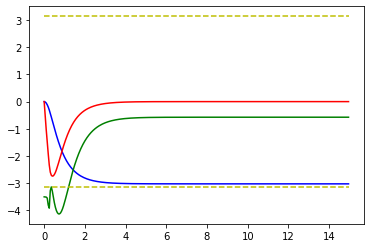

47 tensor(182.2868, grad_fn=<SumBackward0>)


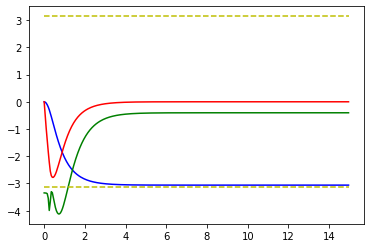

48 tensor(181.1389, grad_fn=<SumBackward0>)


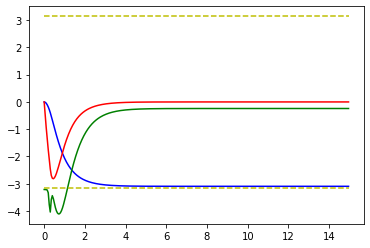

49 tensor(180.9047, grad_fn=<SumBackward0>)


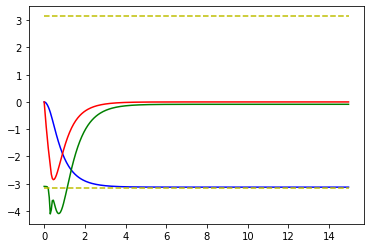

50 tensor(184.5457, grad_fn=<SumBackward0>)


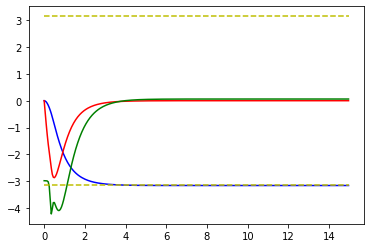

51 tensor(187.3020, grad_fn=<SumBackward0>)


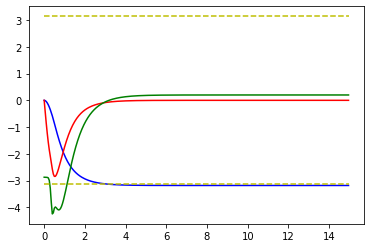

52 tensor(194.5214, grad_fn=<SumBackward0>)


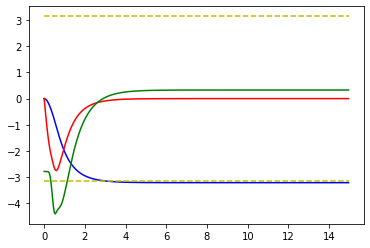

53 tensor(197.5277, grad_fn=<SumBackward0>)


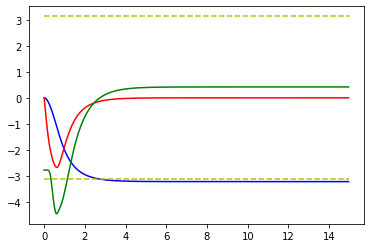

54 tensor(192.9763, grad_fn=<SumBackward0>)


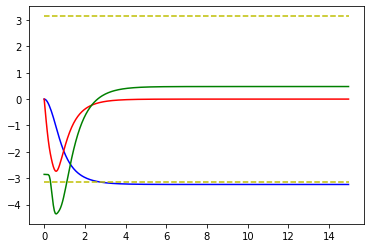

55 tensor(184.9786, grad_fn=<SumBackward0>)


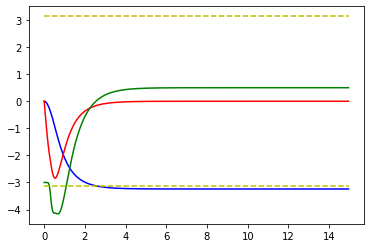

56 tensor(181.0888, grad_fn=<SumBackward0>)


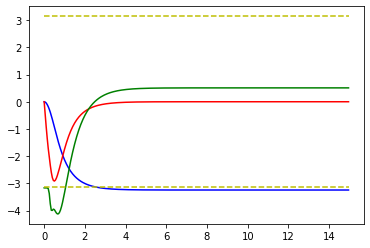

57 tensor(178.2121, grad_fn=<SumBackward0>)


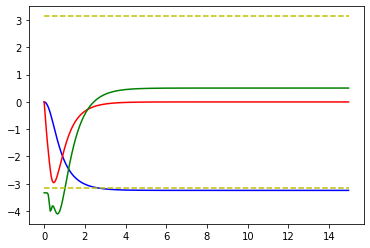

58 tensor(175.6279, grad_fn=<SumBackward0>)


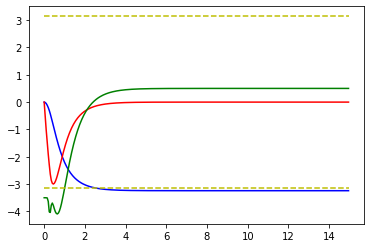

59 tensor(177.0006, grad_fn=<SumBackward0>)


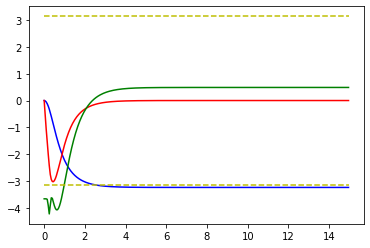

60 tensor(175.4498, grad_fn=<SumBackward0>)


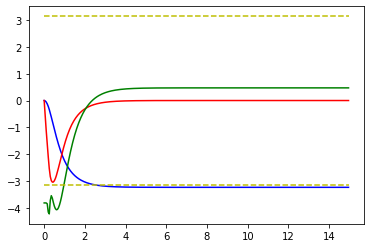

61 tensor(177.4479, grad_fn=<SumBackward0>)


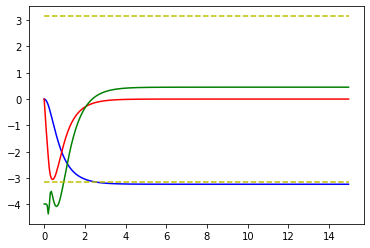

62 tensor(177.9138, grad_fn=<SumBackward0>)


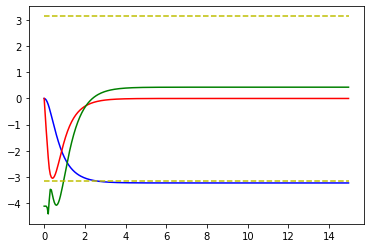

63 tensor(175.9547, grad_fn=<SumBackward0>)


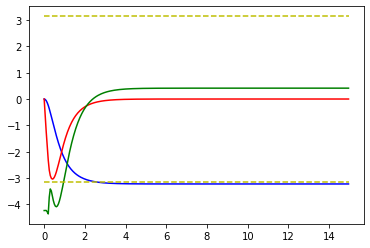

64 tensor(175.5358, grad_fn=<SumBackward0>)


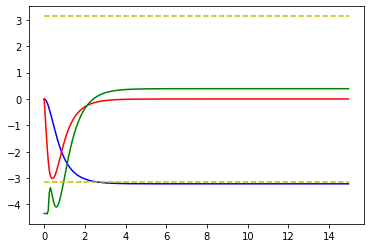

65 tensor(177.1130, grad_fn=<SumBackward0>)


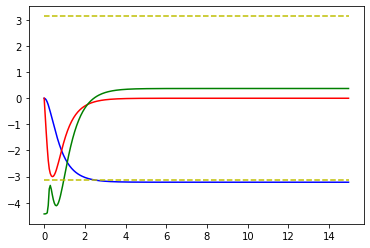

66 tensor(178.4114, grad_fn=<SumBackward0>)


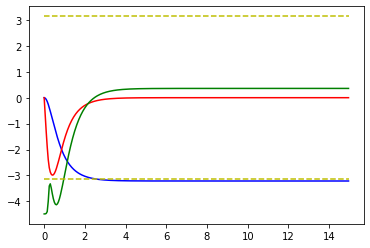

67 tensor(179.0459, grad_fn=<SumBackward0>)


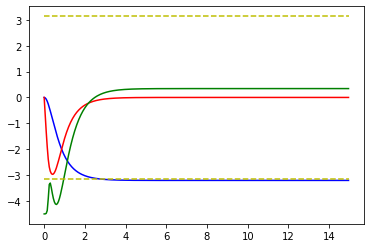

68 tensor(179.0516, grad_fn=<SumBackward0>)


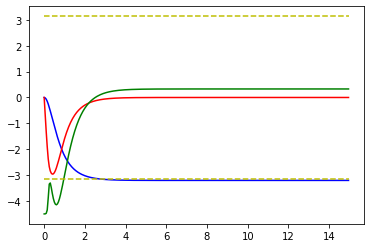

69 tensor(178.4852, grad_fn=<SumBackward0>)


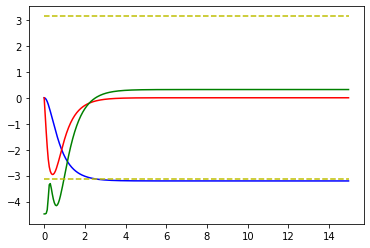

70 tensor(177.4188, grad_fn=<SumBackward0>)


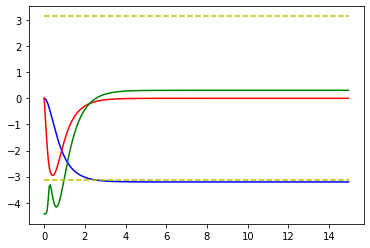

71 tensor(175.9353, grad_fn=<SumBackward0>)


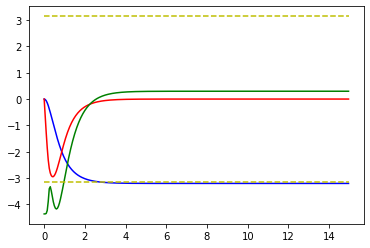

72 tensor(174.1237, grad_fn=<SumBackward0>)


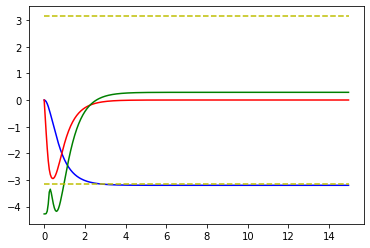

73 tensor(172.2647, grad_fn=<SumBackward0>)


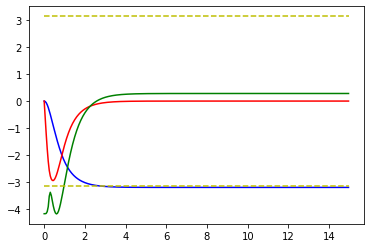

74 tensor(172.4774, grad_fn=<SumBackward0>)


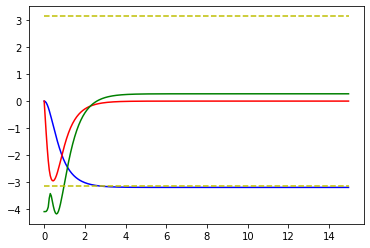

75 tensor(172.2953, grad_fn=<SumBackward0>)


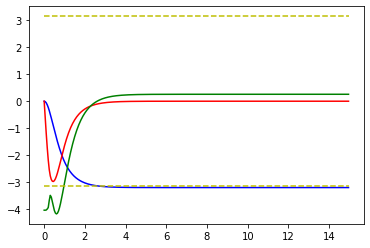

76 tensor(171.7073, grad_fn=<SumBackward0>)


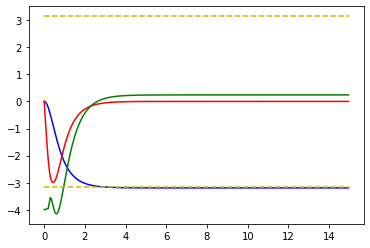

77 tensor(170.7311, grad_fn=<SumBackward0>)


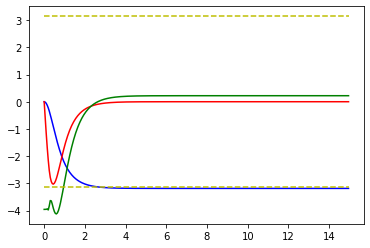

78 tensor(169.4399, grad_fn=<SumBackward0>)


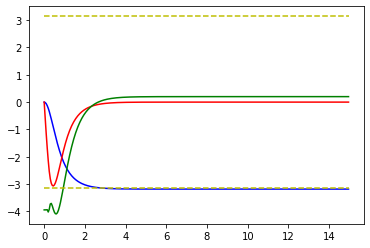

79 tensor(168.4836, grad_fn=<SumBackward0>)


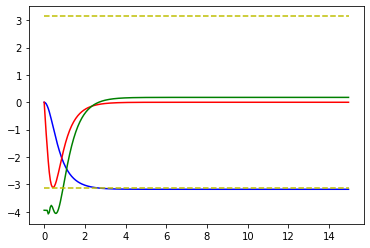

80 tensor(168.8264, grad_fn=<SumBackward0>)


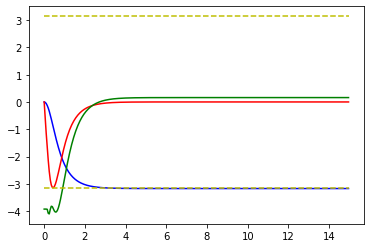

81 tensor(169.5031, grad_fn=<SumBackward0>)


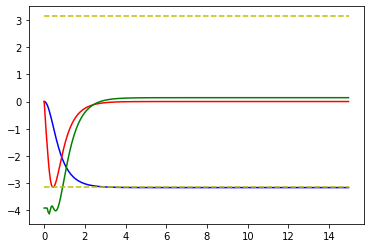

82 tensor(169.2679, grad_fn=<SumBackward0>)


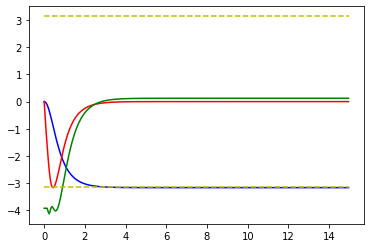

83 tensor(168.2905, grad_fn=<SumBackward0>)


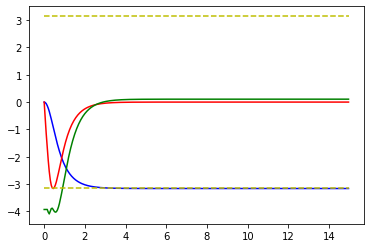

84 tensor(167.2568, grad_fn=<SumBackward0>)


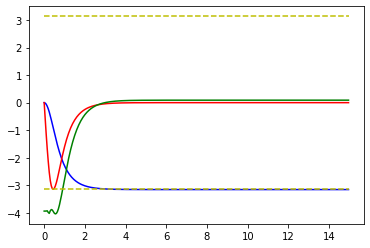

85 tensor(167.4239, grad_fn=<SumBackward0>)


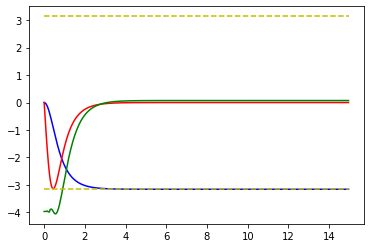

86 tensor(167.2158, grad_fn=<SumBackward0>)


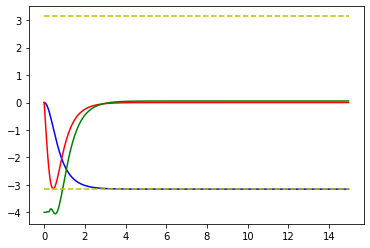

87 tensor(166.6406, grad_fn=<SumBackward0>)


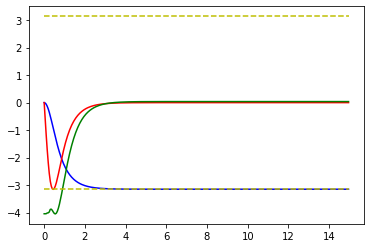

88 tensor(167.2359, grad_fn=<SumBackward0>)


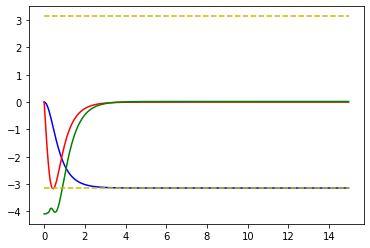

89 tensor(167.4714, grad_fn=<SumBackward0>)


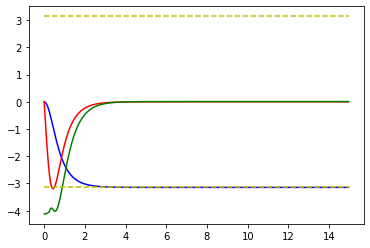

90 tensor(167.2389, grad_fn=<SumBackward0>)


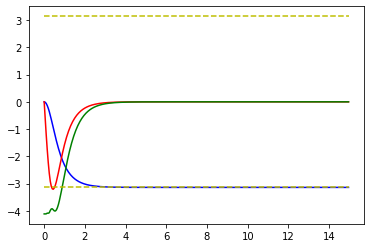

91 tensor(167.0942, grad_fn=<SumBackward0>)


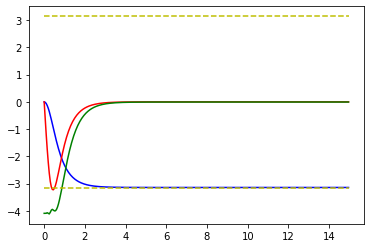

92 tensor(167.0293, grad_fn=<SumBackward0>)


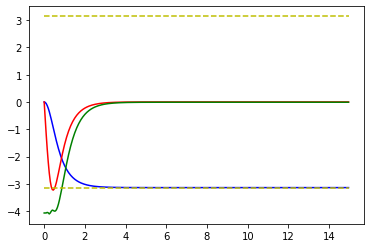

93 tensor(166.1814, grad_fn=<SumBackward0>)


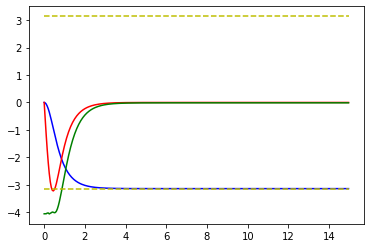

94 tensor(166.1563, grad_fn=<SumBackward0>)


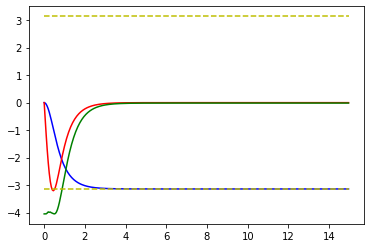

95 tensor(167.3968, grad_fn=<SumBackward0>)


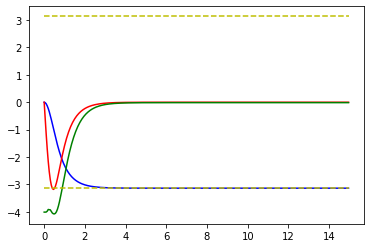

96 tensor(167.9332, grad_fn=<SumBackward0>)


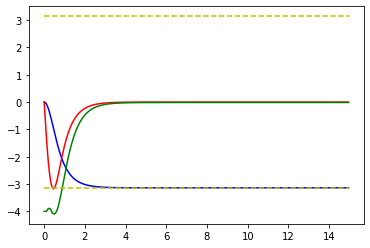

97 tensor(167.6551, grad_fn=<SumBackward0>)


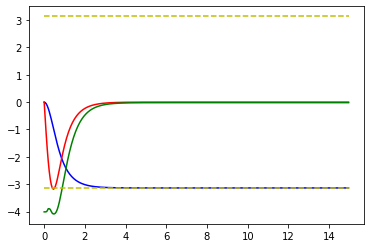

98 tensor(166.6814, grad_fn=<SumBackward0>)


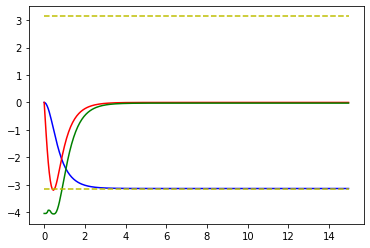

99 tensor(167.0109, grad_fn=<SumBackward0>)


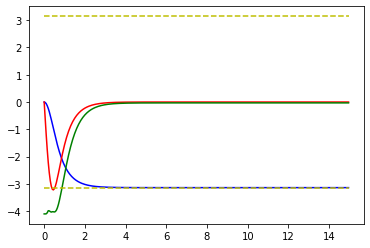

100 tensor(167.2354, grad_fn=<SumBackward0>)


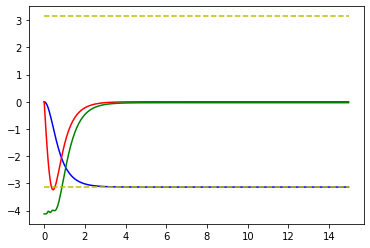

101 tensor(167.3927, grad_fn=<SumBackward0>)


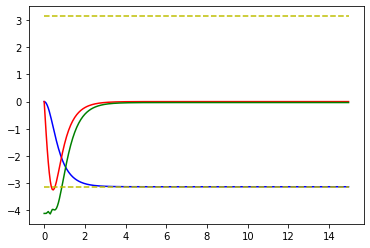

102 tensor(167.2599, grad_fn=<SumBackward0>)


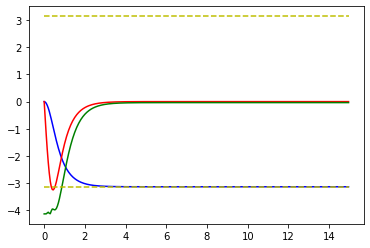

103 tensor(167.2960, grad_fn=<SumBackward0>)


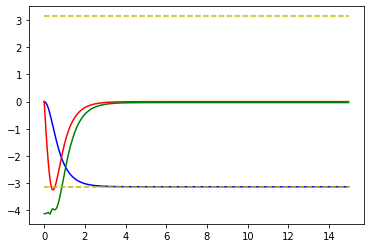

KeyboardInterrupt: 

In [17]:
init_state = torch.tensor([0, 0]).reshape(1, -1).float()
dt = 0.05
steps = 300
num_epoch = 10000

target = torch.cat([torch.ones(steps, 1) * np.pi, torch.ones(steps, 1) * -np.pi], dim=1)

for epoch in range(num_epoch):
    optimizer.zero_grad()
    
    # Generate Trajectory
    # init_states = torch.cat([(torch.rand(127, 2) - 0.5) * 4, init_state], dim=0)
    init_states = init_state
    t_span = torch.linspace(0, dt * (steps-1), steps)
    traj = test_model.trajectory(init_states, t_span)
    dummy = torch.stack([torch.cos(traj[:, :, 0]), torch.sin(traj[:, :, 0]), traj[:, :, 1]], dim=2).reshape(-1, 3)
    actions = test_model.defunc.m.policy(dummy).reshape(steps, 1, 1)
    # actions = pendulumODE.defunc.m.policy(traj).reshape(steps, 1, 1)
    
    loss = total_cost(traj, actions)
    loss.backward()
    optimizer.step()
    
#     def closure():
#         optimizer.zero_grad()
#         init_states = init_state
#         t_span = torch.linspace(0, dt * (steps-1), steps)
#         traj = pendulumODE.trajectory(init_states, t_span)
#         dummy = torch.stack([torch.cos(traj[:, :, 0]), torch.sin(traj[:, :, 0]), traj[:, :, 1]], dim=2).reshape(-1, 3)
#         actions = pendulumODE.defunc.m.policy(dummy).reshape(steps, 1, 1)
#         loss = total_cost(traj, actions)
#         loss.backward()
#         return loss

#     optimizer.step(closure)

    # print statistics
    if epoch % 1 == 0:
        print(epoch, loss)
        plt.plot(t_span.detach().numpy(), traj[:, -1, 0].detach().numpy(), 'b-')
        plt.plot(t_span.detach().numpy(), traj[:, -1, 1].detach().numpy(), 'r-')
        plt.plot(t_span.detach().numpy(), actions[:, -1, :].detach().numpy(), 'g-')
        plt.plot(t_span.detach().numpy(), target, 'y--')
        # plt.ylim(-4, 4)
        plt.show()
print('Finished Training')

In [18]:
test_model.eval()
None

In [19]:
init_state = torch.tensor([0, 0]).reshape(1, -1).float()
t_span = torch.linspace(0, 5, 100)

test_pendulum = Pendulum()
test_pendulum.policy = test_model.defunc.m.policy
test_pendulumODE = NeuralODE(pendulum, sensitivity='adjoint', solver='rk4').to(device)

traj = test_model.trajectory(init_state, t_span)
dummy = torch.stack([torch.cos(traj[:, 0, 0]), torch.sin(traj[:, 0, 0]), traj[:, 0, 1]], dim=1)
actions = pendulumODE.defunc.m.policy(dummy)
# actions = test_model.defunc.m.policy(traj)
print(traj.shape)
print(actions.shape)

torch.Size([100, 1, 2])
torch.Size([100, 1])


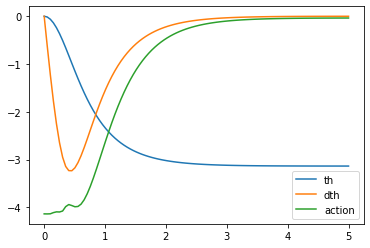

In [20]:
plt.plot(t_span.detach().numpy(), traj[:, 0, 0:2].detach().numpy())
plt.plot(t_span.detach().numpy(), actions.detach().numpy())
plt.legend(['th', 'dth', 'action'])

## Conclusion